# Loan Default Prediction
## Step 5: Modelling (LogReg)
## Table of Content
7. Imports and Data Loading
8. Test LogReg
9. Hyperparameter Tuning
10. Final LogReg Model

## 5.7 Imports and Data Loading

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import brier_score_loss, log_loss
from sklearn.metrics import roc_auc_score, RocCurveDisplay

In [3]:
# As before, load training data
df = pd.read_csv('../data/interim/train.csv')
df.head()

,Unnamed: 0,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,5038,6071496,3,2507.210974,8599.977362,47737.07095,6,618,0
1,8929,5006576,0,3879.481181,4894.867489,70287.44380,4,631,0
2,9024,3181518,0,2517.012371,2958.774379,39506.04322,5,763,0
3,3218,3770987,2,6581.765984,9023.147830,84959.97714,8,711,0
4,8550,3481740,5,5243.031680,27422.854140,85183.17609,4,586,1


In [4]:
# Apply the same feature reduction as before to draw comparison
X = df[['income', 'years_employed', 'fico_score']]
y = df['default']

## 5.8 Test LogReg

We have loaded the training data into variables X and y. Here we will:
1. perform a train/test split
2. build a first LogReg model using default parameters
3. examine the performance of the model

In [5]:
# Perform train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.1, random_state=23)

In [6]:
# Train a first model using default parameters
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
fit_model = model.fit(X_train, y_train)

In [7]:
# Use this model to predict on the test set
y_pred = fit_model.predict(X_test)
y_proba = fit_model.predict_proba(X_test)[:,1]

               precision    recall  f1-score   support

0(no default)       0.82      1.00      0.90       653
   1(default)       0.00      0.00      0.00       147

     accuracy                           0.82       800
    macro avg       0.41      0.50      0.45       800
 weighted avg       0.67      0.82      0.73       800

Brier score loss: 	0.1460115287943058
log loss: 		0.46373583969474713
ROC_AUC score:  0.6289235449156692


/Users/hao/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hao/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hao/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


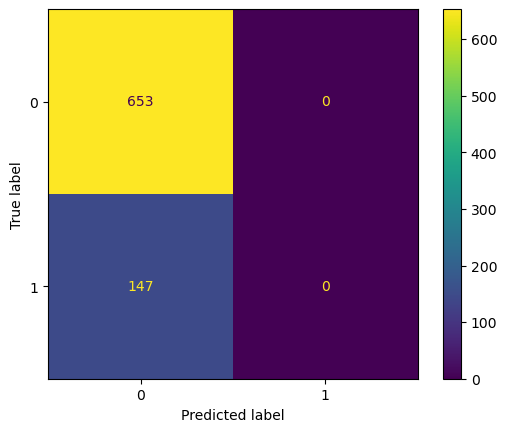

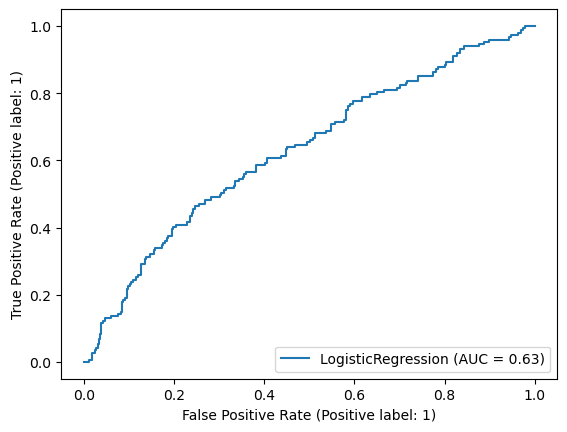

In [8]:
# Take a look at performance metrics
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

target_names = ['0(no default)', '1(default)']
print(classification_report(y_test, y_pred, target_names=target_names))

print('Brier score loss: \t' + str(brier_score_loss(y_test, y_proba)))
print('log loss: \t\t' + str(log_loss(y_test, y_proba)))

print('ROC_AUC score: ', str(roc_auc_score(y_test, y_proba)))
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()

## 5.9 Hyperparameter Tuning
As we can see already, the default LogReg model is performing worse than the default CatBoost model. It will be worthwhile to see if some hyperparameter tuning would improve the performance and by how much.

Here are the default hyperparameters:
penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='deprecated', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None

In [9]:
# Suppress convergence warnings
from sklearn.exceptions import ConvergenceWarning
ConvergenceWarning('ignore')

from sklearn.model_selection import RandomizedSearchCV

clf = LogisticRegression(max_iter=500, penalty='l2')

param_distributions = {'solver': ['lbfgs', 'newton-cholesky'],
                       'C': [0.1, 0.5, 0.75, 1, 5, 10]}

search = RandomizedSearchCV(clf, param_distributions, scoring='roc_auc').fit(X_train, y_train)
print('search done')
print(search.best_params_)

search done
{'solver': 'newton-cholesky', 'C': 0.75}


## 5.6 Final LogReg Model
Using the results of the last section, the best values for the test parameters are:
solver = 'newton-cholesky' (default 'lbfgs')
C = 0.75 (default 1)
Using these parameters, we will train the model and calculate metrics on the validation set.

In [10]:
# Import validation data
df_valid = pd.read_csv('../data/interim/validation.csv')
X_valid = df_valid[['income', 'years_employed', 'fico_score']]
y_valid = df_valid['default']

In [11]:
# Let us examine the performance using this set of hyperparameters
model = LogisticRegression(solver='newton-cholesky', penalty='l2', C=0.75, max_iter=500)
fit_model = model.fit(X, y)

In [12]:
# Use the trained model to make predictions
y_pred = fit_model.predict(X_valid)
y_proba = fit_model.predict_proba(X_valid)[:,1]

               precision    recall  f1-score   support

0(no default)       0.84      0.97      0.90      1624
   1(default)       0.59      0.18      0.28       376

     accuracy                           0.82      2000
    macro avg       0.71      0.58      0.59      2000
 weighted avg       0.79      0.82      0.78      2000

Brier score loss: 	0.12757509999134695
log loss: 		0.4087386060695741
ROC_AUC score:  0.7668041216853578


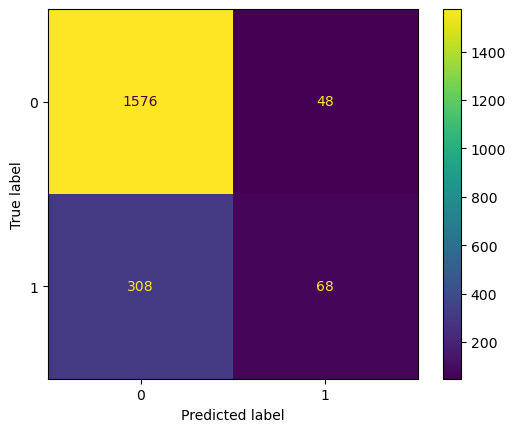

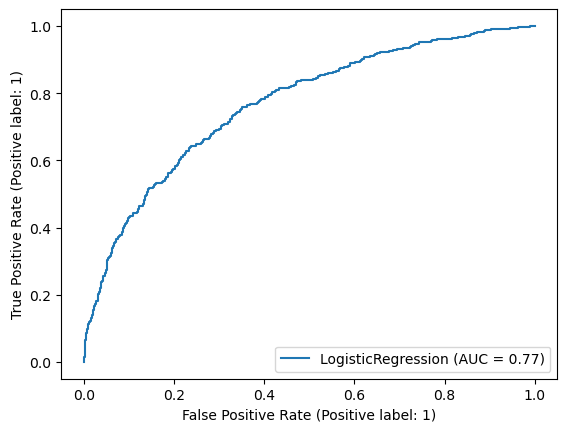

In [13]:
# Generate performance metrics from the predictions
cm = confusion_matrix(y_valid, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

target_names = ['0(no default)', '1(default)']
print(classification_report(y_valid, y_pred, target_names=target_names))

print('Brier score loss: \t' + str(brier_score_loss(y_valid, y_proba)))
print('log loss: \t\t' + str(log_loss(y_valid, y_proba)))

print('ROC_AUC score: ', str(roc_auc_score(y_valid, y_proba)))
RocCurveDisplay.from_estimator(model, X_valid, y_valid)
plt.show()